<a href="https://colab.research.google.com/github/swagata87/school2024iop/blob/main/srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,GlobalAvgPool2D,PReLU )
from tensorflow.keras.optimizers import Adam

# Prepare Data

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/celeba_hq_256/25000.jpg  
  inflating: /content/dataset/celeba_hq_256/25001.jpg  
  inflating: /content/dataset/celeba_hq_256/25002.jpg  
  inflating: /content/dataset/celeba_hq_256/25003.jpg  
  inflating: /content/dataset/celeba_hq_256/25004.jpg  
  inflating: /content/dataset/celeba_hq_256/25005.jpg  
  inflating: /content/dataset/celeba_hq_256/25006.jpg  
  inflating: /content/dataset/celeba_hq_256/25007.jpg  
  inflating: /content/dataset/celeba_hq_256/25008.jpg  
  inflating: /content/dataset/celeba_hq_256/25009.jpg  
  inflating: /content/dataset/celeba_hq_256/25010.jpg  
  inflating: /content/dataset/celeba_hq_256/25011.jpg  
  inflating: /content/dataset/celeba_hq_256/25012.jpg  
  inflating: /content/dataset/celeba_hq_256/25013.jpg  
  inflating: /content/dataset/celeba_hq_256/25014.jpg  
  inflating: /content/dataset/celeba_hq_256/25015.jpg  
  inflating: /content/dataset/celeba_hq_256/25016.jpg

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
B=24
LEARNING_RATE = 1e-4

In [4]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/celeba_hq_256", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 30000 files belonging to 1 classes.


In [5]:
def preprocess(image):
  return tf.image.resize(image,[IM_SHAPE[0]//4,IM_SHAPE[1]//4],method='bicubic')/255,tf.cast(image,tf.float32)/127.5 - 1.0

In [6]:
ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [7]:
len(ds)

235

In [8]:
train_dataset = (
    ds.take(12000)
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
for d1,d2 in train_dataset.take(1):
  print(d1.shape,d2.shape)

(128, 16, 16, 3) (128, 64, 64, 3)


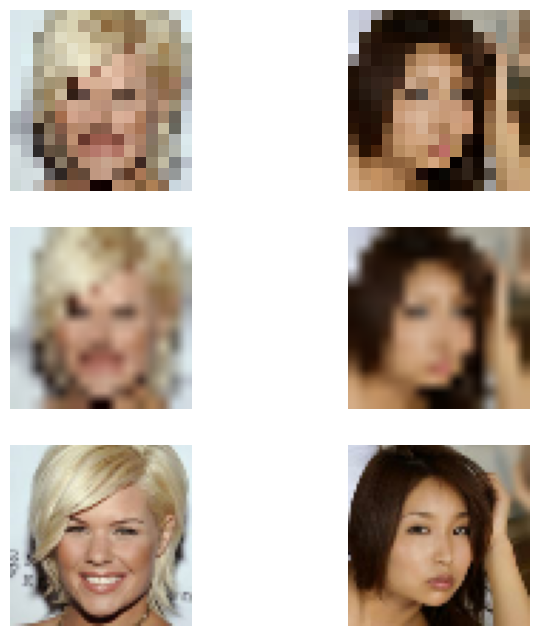

In [10]:
plt.figure(figsize = (8,8))
k=0
n = 6
for i in range(n):
    ax = plt.subplot(3,2, k+1)
    if i<2:
      plt.imshow(d1[i])
    elif i>=2 and i<4:
      plt.imshow(cv2.resize(np.array(d1[i-2]),(64,64)))
    else:
      plt.imshow((d2[i-4]+1)/2)
    plt.axis("off")
    k+=1

# MOdeling

In [11]:
class ResBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='res_block'):
      super(ResBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv_1=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm_1=BatchNormalization()
      self.prelu=PReLU()
      self.conv_2=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm_2=BatchNormalization()

    def call(self,x_in):
      x=self.conv_1(x_in)
      x=self.prelu(self.batch_norm_1(x))
      x=self.conv_2(x)
      x=self.batch_norm_2(x)
      return x+x_in

In [12]:
class UpsampleBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='upsample_block'):
      super(UpsampleBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.prelu=PReLU()
    def call(self,x):
      x=self.conv(x)
      x=tf.nn.depth_to_space(x, 2)
      x=self.prelu(x)
      return x

In [13]:
input_lr=tf.keras.layers.Input(shape=(IM_SHAPE[0]//4,IM_SHAPE[1]//4,3))
input_conv=tf.keras.layers.Conv2D(64,9,1,padding='same')(input_lr)
input_conv=PReLU()(input_conv)

x=input_conv
for i in range(B):
  x=ResBlock(64,3,1,name='res_block_'+str(i))(x)

x=tf.keras.layers.Conv2D(64,9,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)

x+=input_conv

x=UpsampleBlock(256,3,1,name='upsample_block_1')(x)
x=UpsampleBlock(256,3,1,name='upsample_block_2')(x)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(x)

srresnet=tf.keras.models.Model(input_lr,output_sr)
srresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 16, 16, 64)           16384     ['conv2d[0][0]']              
                                                                                                  
 res_block_0 (ResBlock)      (None, 16, 16, 64)           90752     ['p_re_lu[0][0]']             
                                                                                              

In [14]:
class ConvBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='conv_block'):
      super(ConvBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm=BatchNormalization()

    def call(self,x):
      x=self.conv(x)
      x=LeakyReLU()(self.batch_norm(x))
      return x

In [15]:
input_lr=tf.keras.layers.Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for i in range(7):
  disc=ConvBlock(
      channel_nums[i],3,stride_sizes[i],name='conv_block_'+str(i))(disc)
disc = GlobalAvgPool2D()(disc)
disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv_block_0 (ConvBlock)    (None, 32, 32, 64)        37184     
                                                                 
 conv_block_1 (ConvBlock)    (None, 32, 32, 128)       74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 16, 16, 128)       148096    
                                                                 
 conv_block_3 (ConvBlock)    (None, 16, 16, 256)       2961

In [16]:
def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [17]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

80134624/80134624 [==============================] - 1s 0us/step


In [18]:
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break

    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      mse=tf.keras.losses.MeanSquaredError(name='mean_squared_error')
      accumulated_loss+=mse(y_hr,y_sr)*0.006

  return accumulated_loss

In [19]:
def content_loss(y_true,y_pred):
  mse=tf.keras.losses.MeanSquaredError(name='mean_squared_error')
  return mse(y_true,y_pred)+VGG_loss(y_true,y_pred)

In [20]:
class GANMonitor(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch,logs=None):
    plt.figure(figsize = (16,16))
    k=0
    n = 6
    for i in range(n):
      ax = plt.subplot(3,2, k+1)
      if i<2:
        plt.imshow(d1[i])
      elif i>=2 and i<4:
        out=self.model.generator(tf.expand_dims(d1[i-2],axis=0))
        plt.imshow((out[0]+1)/2)
      else:
        plt.imshow((d2[i-4]+1)/2)
      plt.axis("off")
      k+=1

    plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))


In [21]:
class SRGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_disc,loss_gen,):
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_disc=loss_disc
        self.loss_gen=loss_gen
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

      lr_images,hr_images = real_images

      batch_size = tf.shape(hr_images)[0]

      generated_images = self.generator(lr_images)

      real_labels = tf.ones((batch_size, 1))
      fake_labels = tf.zeros((batch_size, 1))

      # Train the discriminator
      with tf.GradientTape() as tape:

          real_predictions = self.discriminator(hr_images)
          d_loss_real = self.loss_disc(real_labels,real_predictions)

          fake_predictions = self.discriminator(generated_images)
          d_loss_fake = self.loss_disc(fake_labels,fake_predictions)

          d_loss = 0.5*(d_loss_fake+d_loss_real)
      grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

      misleading_labels = tf.ones((batch_size, 1))

      with tf.GradientTape() as tape:
          predictions = self.generator(lr_images)
          g_loss = self.loss_gen(hr_images, predictions)
          g_loss=g_loss+1e-3*self.loss_disc(misleading_labels, self.discriminator(predictions))

      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

      # Update metrics
      self.d_loss_metric.update_state(d_loss)
      self.g_loss_metric.update_state(g_loss)
      return {
          "d_loss": self.d_loss_metric.result(),
          "g_loss": self.g_loss_metric.result(),
      }

In [22]:
epochs = 1

gan = SRGAN(discriminator=discriminator, generator=srresnet, )
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_disc=tf.keras.losses.BinaryCrossentropy(),
    loss_gen=content_loss,
)

In [23]:
!mkdir generated

In [ ]:
history=gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor()]
)

     22/Unknown - 1473s 65s/step - d_loss: 0.4573 - g_loss: 0.7499